# ML Assignment 2 - Sample Code
* 雲端硬碟: https://drive.google.com/drive/folders/1Qhr6vo5zB3hdzpEZ8oG243FlVhLYfn4X?usp=sharing
* 蘭花競賽網站: https://tbrain.trendmicro.com.tw/Competitions/Details/20

## 執行方式
依作業要求，在圖像轉換或修改模型架構區塊更改程式碼，更改完成後，可以直接全部執行。
訓練過程及輸出位於最後面。


## 初始設定

In [1]:
!pip install --upgrade numpy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


記得修改cd路徑 這邊ai cup是我自訂的資料夾名稱，副檔會直接產生在colab notebooks下，所以將ai cup這個路徑去掉在執行

In [3]:
%cd /content/drive/MyDrive/ai_cup

/content/drive/MyDrive/ai_cup


In [4]:
from __future__ import print_function, division

import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.hub import load_state_dict_from_url
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchsummary import summary

plt.ion()   # interactive mode
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"
auto_augment_policy = None

## 圖像轉換
### 題目
torchvision.transforms 提供了許多可靠的 API來讓使用者對圖像進行操作，請試著在 data_transforms 當中對訓練集進行轉換(圖像前處理)，當模型訓練到一定程度時，驗證看看使用該方法是否確實對模型準確率造成影響，然後試著解釋使用該轉換方法會對模型訓練產生什麼影響。

* 至少嘗試使用 **五種** 不同的圖像轉換方法，並且找出最佳的方法組合。(使用方法數量為加分bonus的依據)
* 須在報告中註明每一個方法 **在未使用時的準確率**、**使用後的準確率**，並 **說明該方法的目的** 及 **最終最佳組合的準確率**。

### 說明
請在註解區塊中寫入圖像轉換的方法。


In [5]:
from torchvision.transforms.transforms import CenterCrop
from torchvision.transforms.functional import center_crop
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224,224) ),
            ########在此區塊填入圖像轉換方法########
            transforms.RandomCrop(224, padding=28),  # 隨機剪裁


            ########################################
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # 標準化
        ]),
        'val': transforms.Compose([
            transforms.Resize((224,224) ),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # 標準化
        ]),
    }

## 修改模型架構
### 第二題 題目
在本次作業範例中我們使用了CNN來做為整個分類模型的架構。請以第一題中最佳的圖像轉換方法組合，並基於CNN架構增加或減少模型的隱藏層，並觀察修改模型後對原先準確率的影響(即修改模型的意思)

* 至少使用 **三種** 不同隱藏層或不同的修改模型方法(增加或減少模型的隱藏層，並且找出最佳的模型架構。(修改方法多寡為加分bonus的依據)
* 須在報告中註明每一個方法 **在更改前的準確率**、 **更改後的準確率** 及 **最終最佳模型架構的準確率**。

### 第三題 題目
整合題目1、2中準確率最佳的圖像轉換方法組合及模型架構，並將模型輸出改為針對蘭花每一類的機率值。請在報告中註明預測準確率。

### 說明
* 因為模型有套用預訓練的參數，所以更改模型的方式比較複雜，

* 請勿直接更改現有隱藏層的參數(輸入、輸出大小等等)，請用增加或減少的方式來修改模型架構。

* 請注意並計算各隱藏層可接受的輸出入大小，以免產生資料維度前後層對不上的問題。


In [6]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
  """3x3 convolution with padding"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                    padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
  """1x1 convolution"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
              base_width=64, dilation=1, norm_layer=None):
    super(BasicBlock, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    if groups != 1 or base_width != 64:
      raise ValueError('BasicBlock only supports groups=1 and base_width=64')
    if dilation > 1:
      raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
    # Both self.conv1 and self.downsample layers downsample the input when stride != 1
    self.conv1 = conv3x3(inplanes, planes, stride)
    self.bn1 = norm_layer(planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = norm_layer(planes)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

class Bottleneck(nn.Module):
  # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
  # while original implementation places the stride at the first 1x1 convolution(self.conv1)
  # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
  # This variant is also known as ResNet V1.5 and improves accuracy according to
  # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

  expansion = 4

  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                base_width=64, dilation=1, norm_layer=None):
    super(Bottleneck, self).__init__()
    if norm_layer is None:
        norm_layer = nn.BatchNorm2d
    width = int(planes * (base_width / 64.)) * groups
    # Both self.conv2 and self.downsample layers downsample the input when stride != 1
    self.conv1 = conv1x1(inplanes, width)
    self.bn1 = norm_layer(width)
    self.conv2 = conv3x3(width, width, stride, groups, dilation)
    self.bn2 = norm_layer(width)
    self.conv3 = conv1x1(width, planes * self.expansion)
    self.bn3 = norm_layer(planes * self.expansion)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

class MyCNN(nn.Module):
  def __init__(self, block, layers, num_classes=219, zero_init_residual=False,
                groups=1, width_per_group=64, replace_stride_with_dilation=None,
                norm_layer=None):
    super(MyCNN, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    self._norm_layer = norm_layer

    self.inplanes = 64
    self.dilation = 1
    if replace_stride_with_dilation is None:
      # each element in the tuple indicates if we should replace
      # the 2x2 stride with a dilated convolution instead
      replace_stride_with_dilation = [False, False, False]
    if len(replace_stride_with_dilation) != 3:
      raise ValueError("replace_stride_with_dilation should be None "
                          "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
    self.groups = groups
    self.base_width = width_per_group
    self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                            bias=False)
    self.bn1 = norm_layer(self.inplanes)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                    dilate=replace_stride_with_dilation[0])
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                    dilate=replace_stride_with_dilation[1])
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                    dilate=replace_stride_with_dilation[2])
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 * block.expansion, 1000)
    self.myfc = nn.Linear(1000, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

    # Zero-initialize the last BN in each residual branch,
    # so that the residual branch starts with zeros, and each residual block behaves like an identity.
    # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
    if zero_init_residual:
      for m in self.modules():
        if isinstance(m, Bottleneck):
          nn.init.constant_(m.bn3.weight, 0)
        elif isinstance(m, BasicBlock):
          nn.init.constant_(m.bn2.weight, 0)

  def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
      norm_layer = self._norm_layer
      downsample = None
      previous_dilation = self.dilation
      if dilate:
        self.dilation *= stride
        stride = 1
      if stride != 1 or self.inplanes != planes * block.expansion:
        downsample = nn.Sequential(
          conv1x1(self.inplanes, planes * block.expansion, stride),
          norm_layer(planes * block.expansion),
        )

      layers = []
      layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                          self.base_width, previous_dilation, norm_layer))
      self.inplanes = planes * block.expansion
      for _ in range(1, blocks):
          layers.append(block(self.inplanes, planes, groups=self.groups,
                              base_width=self.base_width, dilation=self.dilation,
                              norm_layer=norm_layer))

      return nn.Sequential(*layers)

  def _forward_impl(self, x):
    # See note [TorchScript super()]
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    x - self.relu(x)
    x = self.myfc(x)

    return x

  def forward(self, x):
    return self._forward_impl(x)


## 訓練模型區塊
包含視覺化模型及訓練模型。

In [7]:
def visualize_model(model, device, dataloaders, class_names, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0

  plt.figure(figsize=(18,9))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1

        img_display = np.transpose(inputs.cpu().data[j].numpy(), (1,2,0)) #numpy:CHW, PIL:HWC
        plt.subplot(num_images//2,2,images_so_far),plt.imshow(img_display) #nrow,ncol,image_idx
        plt.title(f'predicted: {class_names[preds[j]]}')
        plt.savefig("test.jpg")
        if images_so_far == num_images:
            model.train(mode=was_training)
            plt.clf()
            return
    plt.clf()
    model.train(mode=was_training)

def imshow(inp, title=None):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  
  #原先Normalize是對每個channel個別做 減去mean, 再除上std
  inp1 = std * inp + mean

  plt.imshow(inp)

  if title is not None:
      plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated
  plt.imshow(inp1)
  if title is not None:
      plt.title(title)
  plt.clf()


def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def train_model(model, criterion, device, dataloaders, dataset_sizes, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_loss, valid_loss = [], []
  train_acc, valid_acc = [], []

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in tqdm(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
      else:
        valid_loss.append(epoch_loss)
        valid_acc.append(epoch_acc)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())


  plt.figure(0)
  plt.plot(range(1,num_epochs+1,1), np.array(train_loss), 'r-', label= "train loss") #relative global step
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.savefig(f"./train_loss.png")
  plt.clf()

  plt.figure(1)
  plt.plot(range(1,num_epochs+1,1), np.array(valid_loss), 'b-', label= "eval loss") #--evaluate_during_training True 在啟用eval
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.savefig(f"./eval_loss.png")
  plt.clf()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  #torch.save(model.state_dict(),"model.pt")
  return model

## 訓練參數 (可調整)
* num_epochs: 訓練回合數
* lr: 訓練速度(learning rate)
* batch_size: 批次(batch)大小

In [9]:
num_epochs = 20
lr = 0.001
batch_size = 64

## 主函式 (勿更動)

Using device cuda:0



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


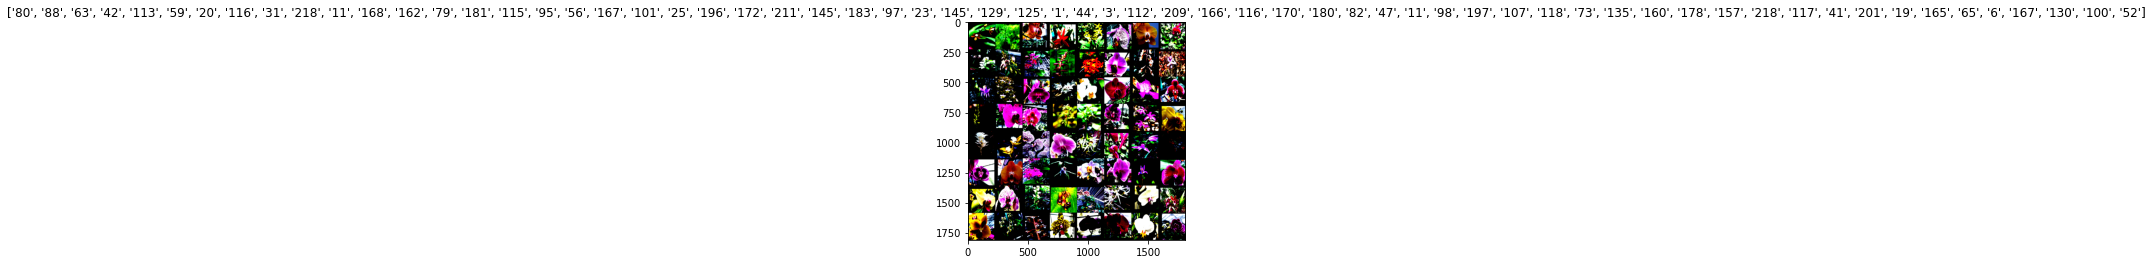

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,456
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

  0%|          | 0/24 [00:22<?, ?it/s]


RuntimeError: ignored

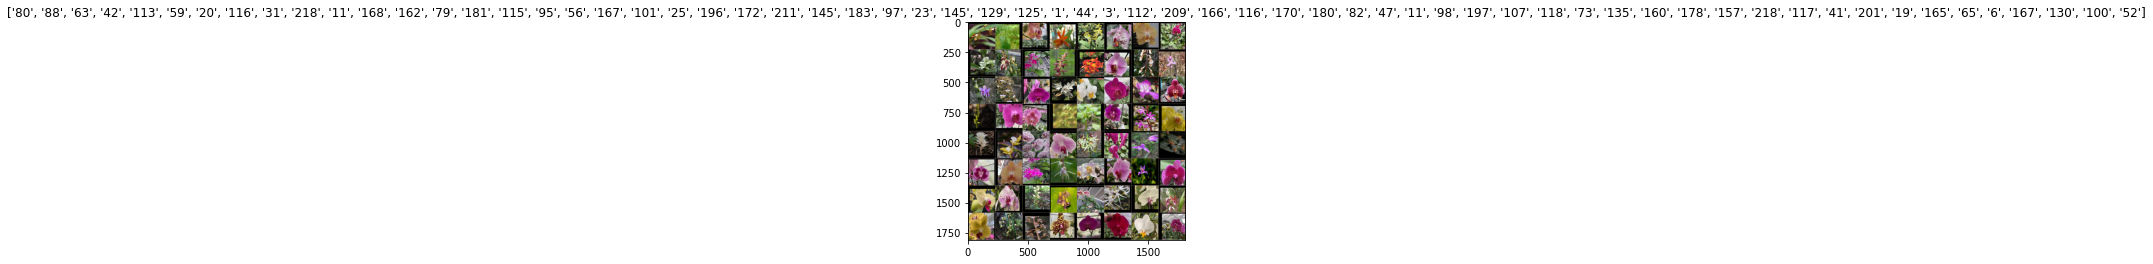

In [10]:
def main():
  num_workers = 2
  momentum = 0.9

  # 資料集載入 =======================================================================
  data_dir = './dataset/training'
  image_datasets = {
    x: datasets.ImageFolder(
      os.path.join(data_dir, x),
      data_transforms[x]
    ) 
    for x in ['train', 'val']
  }
  dataloaders = {
    x: torch.utils.data.DataLoader(
      image_datasets[x], 
      batch_size=batch_size,
      shuffle=True, 
      num_workers=num_workers
    )
    for x in ['train', 'val']
  }
  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  class_names = image_datasets['train'].classes
  # 資料集載入 =======================================================================

  # 設定 CUDA 環境 =======================================================================
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Using device {device}\n")
  # 設定 CUDA 環境 =======================================================================


  # Get a batch of training data
  inputs, classes = next(iter(dataloaders['train']))

  # Make a grid from batch
  out = torchvision.utils.make_grid(inputs)

  imshow(out, title=[class_names[x] for x in classes])

  
  # model =======================================================================
  model_ft = MyCNN(block=Bottleneck, layers=[3, 4, 23, 3], groups=32, width_per_group=8)

  pretrained_dict = load_state_dict_from_url(  # failed
    'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',  # resnext101_32x8d [3, 4, 23, 3] groups=32, width_per_group=8
    progress=True
  )
  


  model_dict = model_ft.state_dict()
  # 1. filter out unnecessary keys
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
  # 2. overwrite entries in the existing state dict
  model_dict.update(pretrained_dict) 
  # 3. load the new state dict
  model_ft.load_state_dict(model_dict)

  summary(model_ft.cuda(),(3,224,224))

  for k,v in model_dict.items():
    print(k)

  model_ft = model_ft.to(device)
  # model =======================================================================

  parameter_count = count_parameters(model_ft)
  print(f"#parameters:{parameter_count}")
  print(f"batch_size:{batch_size}")


  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  model_ft = train_model(
    model_ft, 
    criterion, 
    device, 
    dataloaders, 
    dataset_sizes, 
    optimizer_ft, 
    exp_lr_scheduler,     
    num_epochs=num_epochs
  )

  visualize_model(model_ft, device, dataloaders, class_names)

if __name__ == '__main__':
    main()